# Debiaser for Multiple Variables (DEMV)

_Debiaser for Multiple Variables (DEMV)_ is a pre-processing algorithm to mitigate the bias of binary and multi-class datasets (i.e., datasets where the label has more than 2 values) with any number of sensitive variables.
This algorithm works by perfectly rebalance the sensitive groups of the dataset identified by the combination of all the values of the sensitive variables and all the values of the label [1].

> [1] G. d'Aloisio, A. D'Angelo, A. Di Marco, e G. Stilo, «Debiaser for Multiple Variables to enhance fairness in  classification tasks», Information Processing & Management, vol. 60, mar. 2023, doi: 10.1016/j.ipm.2022.103226.

In [2]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from aif360.sklearn.preprocessing import DEMV 
from aif360.sklearn.datasets import fetch_adult, fetch_compas
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_difference

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

pip install 'aif360[LawSchoolGPA]'


## Load dataset

**Note** 

In this example we use DEMV on binary classification datasets. However, DEMV can be used on multi-class classification datasets as well.

In [11]:
dataset = 'adult'

In [12]:

X, y, sample_weight = fetch_adult()
sensitive_vars = ['sex', 'race']
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)
y = pd.Series(y.factorize(sort=True)[0], index=y.index)
(X_train, X_test,
y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)
ohe = make_column_transformer(
        (OneHotEncoder(sparse=False), X_train.dtypes == 'category'),
        remainder='passthrough', verbose_feature_names_out=False)
X_train  = pd.DataFrame(ohe.fit_transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)
X_train.head()


workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
race sex                                                                  
1    1                      0.0                  0.0                0.0   
     0                      0.0                  0.0                0.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   

          workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
race sex                                                       
1    1                       0.0                         1.0   
     0                       0.0                         1.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   

          workclass_State-gov  workclass_Without-pay  education_10th  \
race sex                                                               
1    1                    0.0                    0.0             0.0   
     0                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             1.0   

          education_11th  education_12th  ...  native-country_Thailand  \
race sex                                  ...                            
1    1               0.0             0.0  ...                      0.0   
     0               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   

          native-country_Trinadad&Tobago  native-country_United-States  \
race sex                                                                 
1    1                               0.0                           1.0   
     0                               0.0                           0.0   
     1                               0.0                           1.0   
     1                               0.0                           0.0   
     1                               0.0                           1.0   

          native-country_Vietnam  native-country_Yugoslavia   age  \
race sex                                                            
1    1                       0.0                        0.0  58.0   
     0                       0.0                        0.0  51.0   
     1                       0.0                        0.0  26.0   
     1                       0.0                        0.0  44.0   
     1                       0.0                        0.0  33.0   

          education-num  capital-gain  capital-loss  hours-per-week  
race sex                                                             
1    1             11.0           0.0           0.0            42.0  
     0             12.0           0.0           0.0            30.0  
     1             14.0           0.0        1887.0            40.0  
     1              3.0           0.0           0.0            40.0  
     1              6.0           0.0           0.0            40.0  

[5 rows x 103 columns]

### Transform the original training data

DEMV is a pre-processing algorithm, meaning that it works directly on the dataset by rebalancing all its sensitive groups.

Here we instantiate DEMV and transform the training data.

In [13]:
demv = DEMV(sensitive_vars)

In [14]:
x_train_new, y_new = demv.fit_transform(X_train, y_train)

In [15]:
x_train_new.head()

workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
sex race                                                                  
1   1                       0.0                  0.0                1.0   
0   0                       0.0                  0.0                1.0   
1   1                       0.0                  0.0                1.0   
    1                       0.0                  0.0                1.0   
    1                       1.0                  0.0                0.0   

          workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
sex race                                                       
1   1                        0.0                         0.0   
0   0                        0.0                         0.0   
1   1                        0.0                         0.0   
    1                        0.0                         0.0   
    1                        0.0                         0.0   

          workclass_State-gov  workclass_Without-pay  education_10th  \
sex race                                                               
1   1                     0.0                    0.0             0.0   
0   0                     0.0                    0.0             0.0   
1   1                     0.0                    0.0             0.0   
    1                     0.0                    0.0             0.0   
    1                     0.0                    0.0             0.0   

          education_11th  education_12th  ...  native-country_Thailand  \
sex race                                  ...                            
1   1                0.0             0.0  ...                      0.0   
0   0                0.0             0.0  ...                      0.0   
1   1                0.0             0.0  ...                      0.0   
    1                0.0             0.0  ...                      0.0   
    1                0.0             0.0  ...                      0.0   

          native-country_Trinadad&Tobago  native-country_United-States  \
sex race                                                                 
1   1                                0.0                           1.0   
0   0                                0.0                           1.0   
1   1                                0.0                           1.0   
    1                                0.0                           1.0   
    1                                0.0                           1.0   

          native-country_Vietnam  native-country_Yugoslavia   age  \
sex race                                                            
1   1                        0.0                        0.0  28.0   
0   0                        0.0                        0.0  23.0   
1   1                        0.0                        0.0  23.0   
    1                        0.0                        0.0  38.0   
    1                        0.0                        0.0  43.0   

          education-num  capital-gain  capital-loss  hours-per-week  
sex race                                                             
1   1              10.0           0.0           0.0            35.0  
0   0               9.0           0.0           0.0            40.0  
1   1               9.0           0.0           0.0            40.0  
    1               9.0           0.0           0.0            43.0  
    1              10.0        2174.0           0.0            40.0  

[5 rows x 103 columns]

In [16]:
y_new

sex  race
1    1       0
0    0       0
1    1       0
     1       0
     1       0
            ..
0    1       0
1    1       0
0    0       1
1    1       1
     1       0
Name: y, Length: 31524, dtype: int64

## Train a classifier algorithm

Since DEMV does not use the instance weights, we can use it with any classifier algorithm. 

#### Metrics with original data

In [17]:
from sklearn.linear_model import LogisticRegression

y_pred = LogisticRegression(solver='liblinear').fit(X_train, y_train).predict(X_test)

In [18]:
display(Markdown("#### Original dataset prediction metrics"))
print("Disparate Impact", disparate_impact_ratio(y_test, y_pred, prot_attr='sex'))
print("Average Odds", average_odds_difference(y_test, y_pred, prot_attr='sex'))

#### Original dataset prediction metrics

Disparate Impact 0.26889803976599136
Average Odds -0.10945486041347308


#### Metrics with transformed data

In [19]:
model = LogisticRegression(solver='liblinear')
model.fit(x_train_new, y_new)
pred_trans = model.predict(X_test)

In [20]:
display(Markdown("#### Transformed dataset prediction metrics"))
print("Disparate impact ", disparate_impact_ratio(y_test, pred_trans, prot_attr='sex'))
print("Average Odds", average_odds_difference(y_test, pred_trans, prot_attr='sex'))

#### Transformed dataset prediction metrics

Disparate impact  0.523176954402241
Average Odds 0.03750140850044231


In [21]:
assert disparate_impact_ratio(y_test, y_pred, prot_attr='sex') < disparate_impact_ratio(y_test, pred_trans, prot_attr='sex')

In [22]:
assert abs(average_odds_difference(y_test, y_pred, prot_attr='sex')) > abs(average_odds_difference(y_test, pred_trans, prot_attr='sex'))

## Plot the balancing of the groups

To have a graphical representation of the behavior of DEMV, we can plot the ratio between the expected size ($W_{exp}$) and the observed size ($W_{obs}$) of each sensitive group at each balancing iteration.

In [23]:
import seaborn as sns
def plot_groups_disparity(disparities):
    fig, ax = plt.subplots()
    for d in disparities:
        sns.lineplot(data=d)
    plt.axhline(y=1, linewidth=2)
    ax.set_ylabel('Group disparity')
    return ax

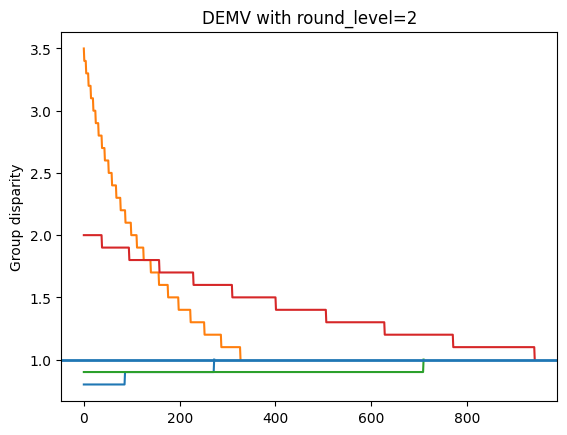

In [24]:
plot_groups_disparity(demv.get_disparities())
plt.title("DEMV with round_level=2")
plt.show()

In [25]:
demv.get_iters()

1184

After 1184 iterations, $W_{exp}/W_{obs}$ of all the groups converges to one. This means that all the groups are totally balanced.
